In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [5]:
#starbucks stock
#open,close-price at the start and end of training day
#high, low- highest n lowest price on that day
#volume- number of shraes traded in that day

df.head(20)

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.3250,27.9200,28.185,7146296,SBUX
1,2013-02-11,28.260,28.2600,27.9300,28.070,5457354,SBUX
2,2013-02-12,28.000,28.2750,27.9750,28.130,8665592,SBUX
3,2013-02-13,28.230,28.2300,27.7500,27.915,7022056,SBUX
4,2013-02-14,27.765,27.9050,27.6750,27.775,8899188,SBUX
5,2013-02-15,27.805,27.8500,27.0850,27.170,18195730,SBUX
6,2013-02-19,27.180,27.3050,27.0100,27.225,11760912,SBUX
7,2013-02-20,27.300,27.4200,26.5900,26.655,12472506,SBUX
8,2013-02-21,26.535,26.8200,26.2600,26.675,13896450,SBUX
9,2013-02-22,26.850,27.1050,26.6400,27.085,11487316,SBUX


In [6]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [7]:
#taking only the closing values as a numpy array

series = df['close'].values
series 

array([28.185, 28.07 , 28.13 , ..., 54.69 , 55.61 , 54.46 ])

In [8]:
series= series.reshape(-1,1)

In [9]:
series

array([[28.185],
       [28.07 ],
       [28.13 ],
       ...,
       [54.69 ],
       [55.61 ],
       [54.46 ]])

In [10]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.

scaler = StandardScaler()
scaler.fit(series[:len(series)//2])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
series = scaler.transform(series).flatten()

In [12]:
series

array([-1.62500489, -1.64174953, -1.6330132 , ...,  2.2342704 ,
        2.36822751,  2.20078112])

In [13]:
len(series)

1259

In [14]:
### build the dataset
# let's see if we can use T past values to predict the next value
#takes windows of len 10, and the target will be the next value

T = 10
D = 1

X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]                 # 1st iter_ 0:10. 2nd iter_ 1:11. 3rd iter= 2:12..........
  X.append(x)
  y = series[t+T]
  Y.append(y)

print(X)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)

[array([-1.62500489, -1.64174953, -1.6330132 , -1.66431839, -1.68470317,
       -1.77279453, -1.76478623, -1.84778139, -1.84486928, -1.78517101]), array([-1.64174953, -1.6330132 , -1.66431839, -1.68470317, -1.77279453,
       -1.76478623, -1.84778139, -1.84486928, -1.78517101, -1.85506167]), array([-1.6330132 , -1.66431839, -1.68470317, -1.77279453, -1.76478623,
       -1.84778139, -1.84486928, -1.78517101, -1.85506167, -1.84996548]), array([-1.66431839, -1.68470317, -1.77279453, -1.76478623, -1.84778139,
       -1.84486928, -1.78517101, -1.85506167, -1.84996548, -1.75604989]), array([-1.68470317, -1.77279453, -1.76478623, -1.84778139, -1.84486928,
       -1.78517101, -1.85506167, -1.84996548, -1.75604989, -1.73566512]), array([-1.77279453, -1.76478623, -1.84778139, -1.84486928, -1.78517101,
       -1.85506167, -1.84996548, -1.75604989, -1.73566512, -1.73420906]), array([-1.76478623, -1.84778139, -1.84486928, -1.78517101, -1.85506167,
       -1.84996548, -1.75604989, -1.73566512, -1.73

In [15]:
X

array([[[-1.62500489],
        [-1.64174953],
        [-1.6330132 ],
        ...,
        [-1.84778139],
        [-1.84486928],
        [-1.78517101]],

       [[-1.64174953],
        [-1.6330132 ],
        [-1.66431839],
        ...,
        [-1.84486928],
        [-1.78517101],
        [-1.85506167]],

       [[-1.6330132 ],
        [-1.66431839],
        [-1.68470317],
        ...,
        [-1.78517101],
        [-1.85506167],
        [-1.84996548]],

       ...,

       [[ 3.21273974],
        [ 3.2535093 ],
        [ 3.12828852],
        ...,
        [ 2.54295418],
        [ 2.42501368],
        [ 2.3915244 ]],

       [[ 3.2535093 ],
        [ 3.12828852],
        [ 3.08751896],
        ...,
        [ 2.42501368],
        [ 2.3915244 ],
        [ 2.2342704 ]],

       [[ 3.12828852],
        [ 3.08751896],
        [ 2.71476873],
        ...,
        [ 2.3915244 ],
        [ 2.2342704 ],
        [ 2.36822751]]])

In [16]:
Y #last values of all x arrays. using the 10 values of x to train and get result Y

array([-1.85506167, -1.84996548, -1.75604989, ...,  2.2342704 ,
        2.36822751,  2.20078112])

In [17]:
N

1249

In [18]:
X.shape

(1249, 10, 1)

In [19]:
Y.shape

(1249,)

In [20]:
### try autoregressive RNN model

from tensorflow.keras.optimizers import SGD, Adam


i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer='adam',
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=500,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 624 samples, validate on 625 samples
Epoch 1/500
624/624 [==============================] - 2s 3ms/sample - loss: 0.6028 - val_loss: 5.0283
Epoch 2/500
624/624 [==============================] - 0s 197us/sample - loss: 0.5032 - val_loss: 4.4297
Epoch 3/500
624/624 [==============================] - 0s 189us/sample - loss: 0.4072 - val_loss: 3.7083
Epoch 4/500
624/624 [==============================] - 0s 201us/sample - loss: 0.3078 - val_loss: 2.8432
Epoch 5/500
624/624 [==============================] - 0s 192us/sample - loss: 0.2159 - val_loss: 1.9424
Epoch 6/500
624/624 [==============================] - 0s 184us/sample - loss: 0.1453 - val_loss: 1.3157
Epoch 7/500
624/624 [==============================] - 0s 189us/sample - loss: 0.1085 - val_loss: 0.9382
Epoch 8/500
624/624 [==============================] - 0s 188us/sample - loss: 0.0908 - val_loss: 0.7424
Epoch 9/500
624/624 [==============================] - 0s 188us/sample - loss: 0.0794 - val_loss: 0.6558
Epoch 10/50

Epoch 78/500
624/624 [==============================] - 0s 201us/sample - loss: 0.0088 - val_loss: 0.0460
Epoch 79/500
624/624 [==============================] - 0s 194us/sample - loss: 0.0088 - val_loss: 0.0459
Epoch 80/500
624/624 [==============================] - 0s 191us/sample - loss: 0.0087 - val_loss: 0.0465
Epoch 81/500
624/624 [==============================] - 0s 194us/sample - loss: 0.0087 - val_loss: 0.0455
Epoch 82/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0086 - val_loss: 0.0450
Epoch 83/500
624/624 [==============================] - 0s 192us/sample - loss: 0.0087 - val_loss: 0.0452
Epoch 84/500
624/624 [==============================] - 0s 188us/sample - loss: 0.0086 - val_loss: 0.0446
Epoch 85/500
624/624 [==============================] - 0s 192us/sample - loss: 0.0086 - val_loss: 0.0454
Epoch 86/500
624/624 [==============================] - 0s 192us/sample - loss: 0.0085 - val_loss: 0.0440
Epoch 87/500
624/624 [========================

Epoch 155/500
624/624 [==============================] - 0s 191us/sample - loss: 0.0066 - val_loss: 0.0358
Epoch 156/500
624/624 [==============================] - 0s 188us/sample - loss: 0.0066 - val_loss: 0.0357
Epoch 157/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0066 - val_loss: 0.0358
Epoch 158/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0065 - val_loss: 0.0357
Epoch 159/500
624/624 [==============================] - ETA: 0s - loss: 0.006 - 0s 184us/sample - loss: 0.0066 - val_loss: 0.0367
Epoch 160/500
624/624 [==============================] - 0s 188us/sample - loss: 0.0066 - val_loss: 0.0352
Epoch 161/500
624/624 [==============================] - 0s 188us/sample - loss: 0.0065 - val_loss: 0.0353
Epoch 162/500
624/624 [==============================] - 0s 188us/sample - loss: 0.0065 - val_loss: 0.0353
Epoch 163/500
624/624 [==============================] - 0s 194us/sample - loss: 0.0064 - val_loss: 0.0351
Epoch 164/500

624/624 [==============================] - 0s 191us/sample - loss: 0.0056 - val_loss: 0.0292
Epoch 232/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0056 - val_loss: 0.0292
Epoch 233/500
624/624 [==============================] - 0s 188us/sample - loss: 0.0056 - val_loss: 0.0290
Epoch 234/500
624/624 [==============================] - 0s 186us/sample - loss: 0.0055 - val_loss: 0.0289
Epoch 235/500
624/624 [==============================] - 0s 191us/sample - loss: 0.0056 - val_loss: 0.0288
Epoch 236/500
624/624 [==============================] - 0s 192us/sample - loss: 0.0055 - val_loss: 0.0293
Epoch 237/500
624/624 [==============================] - 0s 184us/sample - loss: 0.0056 - val_loss: 0.0287
Epoch 238/500
624/624 [==============================] - 0s 184us/sample - loss: 0.0056 - val_loss: 0.0316
Epoch 239/500
624/624 [==============================] - 0s 192us/sample - loss: 0.0056 - val_loss: 0.0286
Epoch 240/500
624/624 [============================

624/624 [==============================] - 0s 192us/sample - loss: 0.0051 - val_loss: 0.0237
Epoch 308/500
624/624 [==============================] - 0s 186us/sample - loss: 0.0051 - val_loss: 0.0237
Epoch 309/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0051 - val_loss: 0.0235
Epoch 310/500
624/624 [==============================] - 0s 196us/sample - loss: 0.0052 - val_loss: 0.0241
Epoch 311/500
624/624 [==============================] - 0s 192us/sample - loss: 0.0051 - val_loss: 0.0238
Epoch 312/500
624/624 [==============================] - 0s 188us/sample - loss: 0.0051 - val_loss: 0.0234
Epoch 313/500
624/624 [==============================] - 0s 191us/sample - loss: 0.0050 - val_loss: 0.0238
Epoch 314/500
624/624 [==============================] - 0s 191us/sample - loss: 0.0051 - val_loss: 0.0234
Epoch 315/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0051 - val_loss: 0.0237
Epoch 316/500
624/624 [============================

624/624 [==============================] - 0s 192us/sample - loss: 0.0048 - val_loss: 0.0216
Epoch 384/500
624/624 [==============================] - 0s 192us/sample - loss: 0.0048 - val_loss: 0.0213
Epoch 385/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0048 - val_loss: 0.0208
Epoch 386/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0048 - val_loss: 0.0210
Epoch 387/500
624/624 [==============================] - 0s 194us/sample - loss: 0.0048 - val_loss: 0.0212
Epoch 388/500
624/624 [==============================] - 0s 188us/sample - loss: 0.0048 - val_loss: 0.0207
Epoch 389/500
624/624 [==============================] - 0s 183us/sample - loss: 0.0048 - val_loss: 0.0219
Epoch 390/500
624/624 [==============================] - 0s 191us/sample - loss: 0.0049 - val_loss: 0.0206
Epoch 391/500
624/624 [==============================] - 0s 191us/sample - loss: 0.0049 - val_loss: 0.0209
Epoch 392/500
624/624 [============================

624/624 [==============================] - 0s 189us/sample - loss: 0.0047 - val_loss: 0.0199
Epoch 460/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0047 - val_loss: 0.0189
Epoch 461/500
624/624 [==============================] - 0s 184us/sample - loss: 0.0048 - val_loss: 0.0186
Epoch 462/500
624/624 [==============================] - 0s 196us/sample - loss: 0.0048 - val_loss: 0.0195
Epoch 463/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0048 - val_loss: 0.0194
Epoch 464/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0048 - val_loss: 0.0186
Epoch 465/500
624/624 [==============================] - 0s 186us/sample - loss: 0.0048 - val_loss: 0.0192
Epoch 466/500
624/624 [==============================] - 0s 191us/sample - loss: 0.0048 - val_loss: 0.0205
Epoch 467/500
624/624 [==============================] - 0s 189us/sample - loss: 0.0049 - val_loss: 0.0185
Epoch 468/500
624/624 [============================

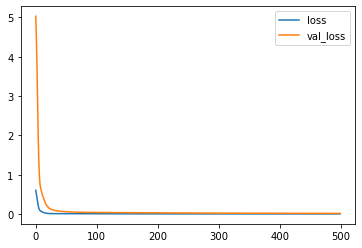

In [21]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


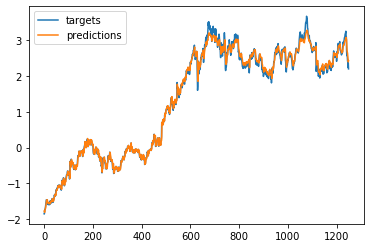

In [22]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

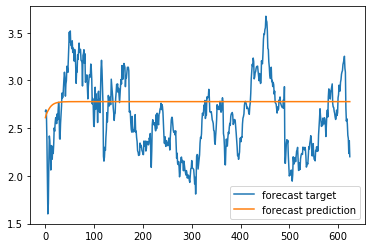

In [23]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()